<a href="https://colab.research.google.com/github/sailalitha96/Lung-Nodule-Detection/blob/master/Squeezenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
from sklearn.utils import class_weight
from scipy.misc import imread
from joblib import Parallel, delayed
import tflearn as tf
from tflearn.data_utils import build_hdf5_image_dataset
from scipy.ndimage import rotate, imread
import h5py
import numpy as np 
import pandas as pd
%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None
from keras.layers import Input, merge
from keras.layers import Convolution2D , concatenate ,Conv2D,Dense
from keras.layers import Activation,Dropout, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam ,SGD,RMSprop
from keras.utils import  to_categorical
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
# print(matplotlib.__file__)
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *

In [0]:
# Load HDF5 dataset
def load_hdf_dataset(mode):
    h5_file = h5py.File(mode+ 'dataset.h5', 'r')
    images = h5_file ['X']
    labels = h5_file ['Y'][:]
    
    images = images[:,:,:].reshape([-1,50,50,1])
    h5_file.close()
    return images, labels 




train_images , tr_labels = load_hdf_dataset('train_again')

    

val_images , val_labels = load_hdf_dataset('val_again')

# images = np.concatenate((train_images,val_images))

# labels  = np.concatenate((tr_labels,val_labels))

# getting indexes
lab_0 = tr_labels[:,0] 
zeros_class= np.where(lab_0 ==1)
lab_1 = tr_labels[:,1]
ones_class= np.where(lab_1 ==1)

for no in zeros_class:
    train_0 = train_images[no,:,:,:]
    train_labels_0 = tr_labels[no,:]

for no in ones_class:
    
    train_1 = train_images[no,:,:,:]
    train_labels_1 = tr_labels[no,:]


train_0 = train_0[ :len(train_labels_1), :,:,:]
train_labels_0= train_labels_0[ :len(train_labels_1), :]

images = np.concatenate((train_0,train_1))
images = np.asarray(images)

labels =  np.concatenate((train_labels_0,train_labels_1))
labels = np.asarray(labels)
labels.shape


(5196, 2)

In [0]:
# y_score = []
def build_squeezenet(input_shape):
    
    input_layer = Input(shape = input_shape)
    
    out = Conv2D(96, kernel_size =(3, 3), activation='relu')(input_layer)
    out = MaxPooling2D(pool_size=2, strides=None, padding='valid')(out)
    # no mxpooling done since small images 
    out = fire_module(out,squeeze =16 , expansion =64)
    out = fire_module(out,squeeze = 16 , expansion=64)
    
    out = fire_module(out,squeeze= 32,expansion = 128)
    out = fire_module(out,squeeze= 32,expansion = 128)
    
    out = fire_module(out , squeeze = 48 ,expansion=192)
    out = fire_module(out,squeeze = 48 , expansion = 192)
    
    out = fire_module(out,squeeze = 64 , expansion = 256)
    out = fire_module(out,squeeze = 64 , expansion = 256)
    
    out = Dropout(0.5)(out)
    out = Conv2D(32,kernel_size=(1,1),padding='valid',activation='relu')(out)
    out = GlobalAveragePooling2D()(out)
    out = Dense(2, activation="softmax")(out)
#     y_score =out[:,]   
    model = Model(input_layer, out, name='squeezenet')
    return model  


In [0]:
def fire_module(input_layer, squeeze =16 , expansion =32):

# a definition for fire module et.al https://github.com/rcmalli/keras-squeezenet/
# inspiration out = tf.map_fn(lambda x: threshold_binarize(x, threshold=0.5) , out, dtype=tf.int64)
# squeezing using 1x1 kernel and expansion with 1x1 and 3x3. Concatenate the output to get best result.

    fire_sq = Conv2D(squeeze,1,1,activation= 'relu')(input_layer)
    fire_exp1 = Conv2D(expansion ,kernel_size=(1,1),activation='relu',padding='valid')(fire_sq)
    fire_exp2 = Conv2D(expansion ,kernel_size=(3,3),activation='relu',padding='same')(fire_sq)
    out = concatenate([fire_exp1,fire_exp2], axis=3)

    return out

In [0]:
del model_dw
model_dw = build_squeezenet(input_shape= (50,50,1))

# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
sgd = Adam(lr=0.0001)
model_dw.compile(
    optimizer=sgd, loss='categorical_crossentropy',
    metrics=['accuracy'])

# weights = class_weight.compute_class_weight('balanced',
#                                             np.unique(val_labels[:,0]) ,
#                                             val_labels[:,0])

wt = np.array([ 0.4,0.6])
# model_dw.summary()
model_dw.fit(x=train_images, 
            y=tr_labels, 
            batch_size=32,
            epochs=20, 
            verbose=1,  
#             validation_split=0.2,
            class_weight= wt,
            validation_data=(val_images,val_labels), 
            shuffle=True)

# pred = model_dw.predict(val_images)


C:\Users\Sailalitha\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu")`
  import sys
C:\Users\Sailalitha\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  import sys
C:\Users\Sailalitha\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 1), activation="relu")`
  import sys
C:\Users\Sailalitha\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu")`
  import sys


Train on 6055 samples, validate on 1501 samples
Epoch 1/20
6055/6055 [==============================] - 72s 12ms/step - loss: 0.6851 - acc: 0.5709 - val_loss: 0.6773 - val_acc: 0.5803
Epoch 2/20
6055/6055 [==============================] - 33s 5ms/step - loss: 0.6733 - acc: 0.5688 - val_loss: 0.6565 - val_acc: 0.5836
Epoch 3/20
6055/6055 [==============================] - 33s 5ms/step - loss: 0.6558 - acc: 0.5794 - val_loss: 0.6274 - val_acc: 0.6316
Epoch 4/20
6055/6055 [==============================] - 33s 5ms/step - loss: 0.5991 - acc: 0.6639 - val_loss: 0.5734 - val_acc: 0.6809
Epoch 5/20
6055/6055 [==============================] - 33s 5ms/step - loss: 0.5691 - acc: 0.7007 - val_loss: 0.5655 - val_acc: 0.7089
Epoch 6/20
6055/6055 [==============================] - 33s 5ms/step - loss: 0.5605 - acc: 0.7069 - val_loss: 0.5527 - val_acc: 0.7202
Epoch 7/20
6055/6055 [==============================] - 33s 5ms/step - loss: 0.5394 - acc: 0.7174 - val_loss: 0.5390 - val_acc: 0.7275
Epoch 

In [0]:
pred = model_dw.predict(val_images)

In [0]:
y_score = pred[:,1]
y_sq = pd.DataFrame(y_score)
y_sq.to_csv('texts.csv')

In [0]:
y_true=val_labels[:,1]

0.9063728974176736


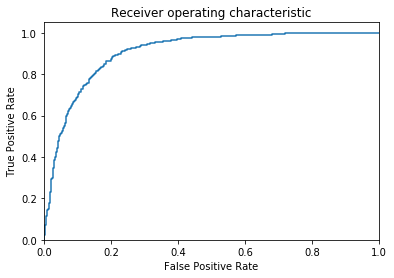

In [0]:
pred = model_dw.predict(val_images)
y_score = pred[:,1]
y_true=val_labels[:,1]

from sklearn.metrics import roc_curve , confusion_matrix 


fpr , tpr, thres = roc_curve(y_true , y_score , pos_label = 1) 

y= []
for i in range(len(y_score)):
    if (y_score[i]>=0.5):
        y.append(1)
    else :
        y.append(0)

y = np.asarray(y)
y

tn , fp , fn , tp = confusion_matrix(y_true, y).ravel()
tn , fp , fn , tp



import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc , roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_true, y_score))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

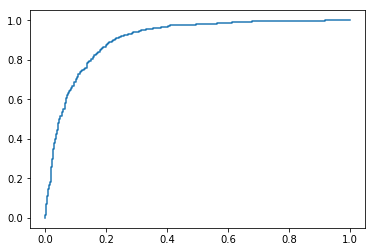

In [0]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr)

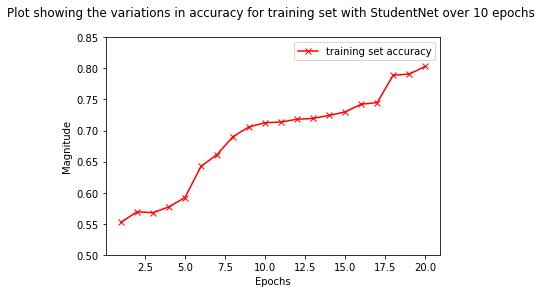

In [0]:
## training plots 

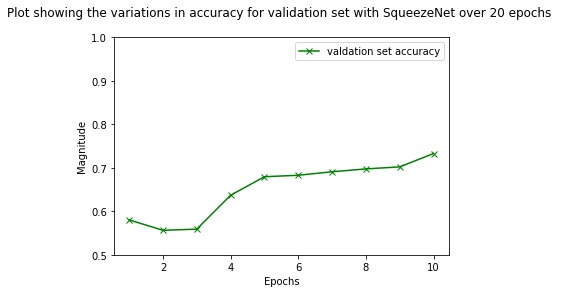

In [0]:
## validating plots